**I. Data Preparation**

In [1]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 200 kB 50.2 MB/s 
     |████████████████████████████████| 199 kB 52.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=1c5a25c3b3c3c0470aafdf003ed8ab2e5ef91d751d4bba40330ab4703b6e22f9
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as fn

In [3]:
# Creating another spark instance
spark2 = SparkSession.builder.master("local[*]").appName("UNSW_NB15_Analysis").getOrCreate()

In [4]:
df = spark2.read.format("csv") \
      .option("header", True) \
      .option("inferSchema", True) \
      .load("/content/drive/MyDrive/UNSW_NB15_datasets/unsw_nb15_bc_dataset.csv")

In [8]:
df.show(10)

+---+-------------+-----+-------------+------+-----+-----+---------+------+------+----+----+-----+-----+-----------+-----------+-----+-----+----+----+----------+---------+-------+-------+-----------+-----------+---------+---------+----------+----------+---------+---------+-------+-------+-------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+-------+
|_c0|        srcip|sport|        dstip|dsport|proto|State|      dur|sbytes|dbytes|sttl|dttl|sloss|dloss|      sload|      dload|spkts|dpkts|swin|dwin|     stcpb|    dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     sjit|     djit|     stime|     ltime|  sintpkt|  dintpkt| tcprtt| synack| ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|service|
+---+-------------+-----+---

In [9]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- State: string (nullable = true)
 |-- dur: double (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: double (nullable = true)
 |-- dloss: double (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: integer (nullable = true)
 |-- dtcpb: integer (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-- 

In [10]:
# Checking for duplicate rows
print('Count of rows: {}'.format(df.count()))
print('Count of distinct rows: {}'.format(df.distinct().count()))

Count of rows: 2059114
Count of distinct rows: 2059114


In [12]:
# Count if there are missing value
df.agg(*[(1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing') for c in df.columns]).show()

+-----------+-------------+-------------+-------------+--------------+-------------+-------------+-----------+--------------+--------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+---------------+---------------+-------------------+-------------------+------------+------------+-------------+-------------+---------------+---------------+--------------+--------------+--------------+-----------------------+--------------------+------------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------------------------+----------------------+------------------+-------------+---------------+
|_c0_missing|srcip_missing|sport_missing|dstip_missing|dsport_missing|proto_missing|State_missing|dur_missing|sbytes_missing|dbytes_missing|sttl_missing|dttl_missing|sloss_missing|dlos

*It appears that there are no more duplicate rows and missing values in the dataset.* 


**II. Preprocessing**


In [5]:
import pyspark.ml.feature as ft
import pyspark.ml.stat as st
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
# Selecting relevant columns
df = df.select(["dur", "proto", "service", "state", "spkts", "dpkts", "sbytes", "dbytes", "sttl", "dttl", "sload", "dload", "sloss", "dloss", "swin", "dwin", "stcpb", "dtcpb", "smeansz", "dmeansz", "trans_depth", "res_bdy_len", "sjit", "djit", "sintpkt", "dintpkt", "tcprtt", "is_ftp_login", "attack_cat", "label"])

In [7]:
# Extract string and numeric for indexing and encoding preparation except for label
def split_str_numeric(df):
  string_columns = [c[0] for c in df.dtypes if 'string' in c]
  num_columns = [c[0] for c in df.dtypes if 'int' in c or 'float' in c and c[0] != 'label']
  return [string_columns, num_columns]

In [8]:
# Method for string indexer and OneHotEncoding
def features_encoding(string_columns,int_columns, df):
  # for str type
  indexers = [ft.StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in string_columns]

  encoders = [ft.StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol()))
  for indexer in indexers]

  assemblerStr = ft.VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "str")

  pipelineStr = Pipeline(stages = indexers + encoders + [assemblerStr])
  df = pipelineStr.fit(df).transform(df)

  # For numeric type
  assemblerInt = ft.VectorAssembler(inputCols = int_columns, outputCol = "num")

  pipelineInt = Pipeline(stages = [assemblerInt])
  df = pipelineInt.fit(df).transform(df)

  assembler = ft.VectorAssembler(inputCols = ["str", "num"], outputCol = "features")

  pipeline = Pipeline(stages = [assembler])
  encoded_df = pipeline.fit(df).transform(df)
  return encoded_df

In [9]:
# execute split function to separate type of columns
str_col, num_col = split_str_numeric(df)

# Extract features column name
all_features_name = str_col + num_col

# For indexing and one hot encoding
encoded_df = features_encoding(str_col, num_col, df)

**III. Getting the correlation for features selection**


In [10]:
# Convert feature matrix into dataframe
matrix = st.Correlation.corr(encoded_df, "features").collect()[0][0]
corrMatrix = matrix.toArray().tolist()
df_corr = spark2.createDataFrame(corrMatrix,all_features_name)
df_corr.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               proto|               state|          attack_cat|               spkts|               dpkts|              sbytes|              dbytes|                sttl|                dttl|                swin|                dwin|               stcpb|               dtcpb|             smeansz|             dmeansz|         trans_depth|         res_bdy_len|        is_ftp_login|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

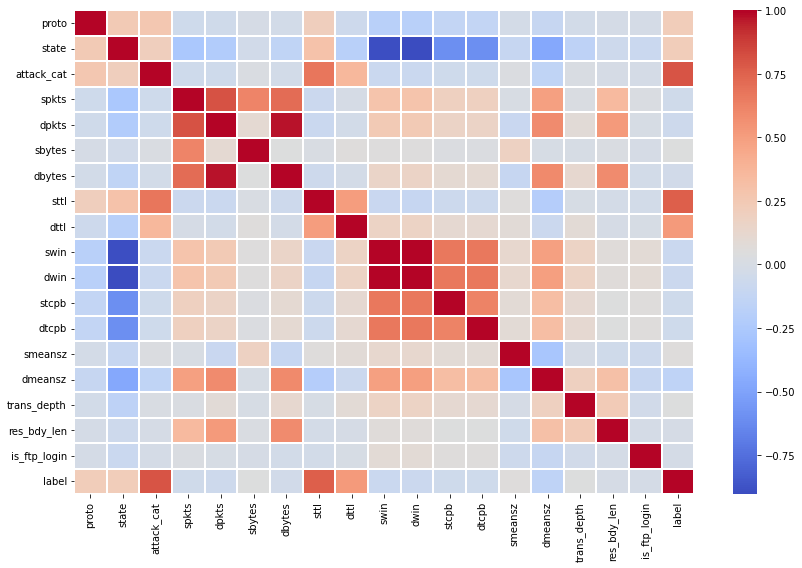

In [11]:
# Plotting the selected columns
%matplotlib inline
corr_plot = df_corr.toPandas()
fig, axes = plt.subplots(figsize=(12,8))
ax = plt.axes()
ax = sns.heatmap(corr_plot,cmap='coolwarm',linecolor='white',linewidths=1)
ax.set_yticklabels(
    ax.get_xticklabels(),
    rotation=360,
    horizontalalignment='right'
);
plt.tight_layout()

In [20]:
for i, row in enumerate(corr_plot["label"]):
  if row > 0 and row < 1:
    print(all_features_name[i], ": ",row)

proto :  0.22049377529482903
state :  0.22153018594209306
attack_cat :  0.8024953601711636
sbytes :  0.04568154694688885
sttl :  0.7659793823626289
dttl :  0.5221387237277988
smeansz :  0.05692127326768381
trans_depth :  0.04645208078442254


In [12]:
# Extracting the eight positive correlated features
bc_columns = [all_features_name[i] for i, row in enumerate(corr_plot["label"]) if row > 0 and row <1]
print(bc_columns)

['proto', 'state', 'attack_cat', 'sbytes', 'sttl', 'dttl', 'smeansz', 'trans_depth']


In [14]:
bc_df = df.select(bc_columns + ["label"])
bc_df.show(10)

+-----+-----+----------+------+----+----+-------+-----------+-----+
|proto|state|attack_cat|sbytes|sttl|dttl|smeansz|trans_depth|label|
+-----+-----+----------+------+----+----+-------+-----------+-----+
|  arp|  CON|    Normal|   184|   0|   0|     46|          0|    0|
|  arp|  INT|    Normal|    46|   0|   0|     46|          0|    0|
|  arp|  CON|    Normal|    56|   0|   0|     28|          0|    0|
|  arp|  INT|    Normal|    46|   0|   0|     46|          0|    0|
|  arp|  INT|    Normal|    46|   0|   0|     46|          0|    0|
| ospf|  REQ|    Normal|   384|   1|   0|     64|          0|    0|
| ospf|  REQ|    Normal|   384|   1|   0|     64|          0|    0|
|  udp|  INT|    Normal|   178|  29|   0|     89|          0|    0|
|  tcp|  FIN|    Normal|  2646|  31|  29|     63|          0|    0|
|  tcp|  FIN|    Normal|  2646|  31|  29|     63|          0|    0|
+-----+-----+----------+------+----+----+-------+-----------+-----+
only showing top 10 rows



In [15]:
# Performing indexing and one hot encoding for correlated features to prepare for classification training
str_col, num_col = split_str_numeric(bc_df)
encoded_bc_df = features_encoding(str_col, num_col, bc_df)
encoded_bc_df.show(10)

+-----+-----+----------+------+----+----+-------+-----------+-----+-------------+-------------+------------------+---------------------+---------------------+--------------------------+-------------+--------------------+--------------------+
|proto|state|attack_cat|sbytes|sttl|dttl|smeansz|trans_depth|label|proto_indexed|state_indexed|attack_cat_indexed|proto_indexed_encoded|state_indexed_encoded|attack_cat_indexed_encoded|          str|                 num|            features|
+-----+-----+----------+------+----+----+-------+-----------+-----+-------------+-------------+------------------+---------------------+---------------------+--------------------------+-------------+--------------------+--------------------+
|  arp|  CON|    Normal|   184|   0|   0|     46|          0|    0|          2.0|          1.0|               0.0|                  2.0|                  1.0|                       0.0|[2.0,1.0,0.0]|(6,[0,3],[184.0,4...|(9,[0,1,3,6],[2.0...|
|  arp|  INT|    Normal|    46| 

**IV. Training and fitting the Model**

In [16]:
# Importing ML libraries
import pyspark.ml.classification as cl
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [25]:
# Splitting the data
df_train, df_test = encoded_bc_df.randomSplit([0.7,0.3], seed=88)

In [26]:
# Using Logistic Regresion
lr = cl.LogisticRegression(
    maxIter=10,
    regParam=0.01,
    labelCol="label"
)

In [27]:
lrModel = lr.fit(df_train)
lrpredictions = lrModel.transform(df_test)
lrpredictions.filter(lrpredictions['prediction'] == 0) \
    .select("attack_cat","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+-----+----------+
|attack_cat|                   probability|label|prediction|
+----------+------------------------------+-----+----------+
|    Normal|[0.9986928315830121,0.00130...|    0|       0.0|
|    Normal|[0.9986928315830121,0.00130...|    0|       0.0|
|    Normal|[0.9986002288911991,0.00139...|    0|       0.0|
|    Normal|[0.9985296104136245,0.00147...|    0|       0.0|
|    Normal|[0.9984871682616662,0.00151...|    0|       0.0|
|    Normal|[0.9984597432417215,0.00154...|    0|       0.0|
|    Normal|[0.9984574785318228,0.00154...|    0|       0.0|
|    Normal|[0.9984574785318228,0.00154...|    0|       0.0|
|    Normal|[0.9984574785318228,0.00154...|    0|       0.0|
|    Normal|[0.9984574785318228,0.00154...|    0|       0.0|
+----------+------------------------------+-----+----------+
only showing top 10 rows



In [28]:
lrevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Accuracy:', lrevaluator.evaluate(lrpredictions))

Accuracy: 0.9999999800950727


In [29]:
lrpredictions.select("attack_cat","prediction","label").groupby("attack_cat","prediction","label").count().show()

+---------------+----------+-----+------+
|     attack_cat|prediction|label| count|
+---------------+----------+-----+------+
|       Exploits|       1.0|    1|  8279|
|       Fuzzers |       1.0|    1|  5336|
|      Shellcode|       1.0|    1|    60|
|            DoS|       1.0|    1|  1723|
|         Normal|       0.0|    0|587625|
|       Analysis|       1.0|    1|   633|
|       Backdoor|       1.0|    1|   527|
|        Fuzzers|       1.0|    1|  1221|
|        Generic|       1.0|    1|  7554|
|          Worms|       1.0|    1|    61|
|Reconnaissance |       1.0|    1|  3420|
|      Backdoors|       1.0|    1|    78|
| Reconnaissance|       1.0|    1|   492|
|     Shellcode |       1.0|    1|   368|
|         Normal|       1.0|    0|     3|
+---------------+----------+-----+------+



In [32]:
# One vs Rest
df_train, df_test = encoded_bc_df.randomSplit([0.7,0.3], seed=88)

# Instantiate the One Vs Rest Classifier
ovr = cl.OneVsRest(classifier=lr)

# Train and Test the multiclass model
ovrModel = ovr.fit(df_train)
ovrpredictions = ovrModel.transform(df_test)
ovrpredictions.filter(ovrpredictions['prediction'] == 0) \
    .select("attack_cat","rawPrediction","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+-----+----------+
|attack_cat|                 rawPrediction|label|prediction|
+----------+------------------------------+-----+----------+
|    Normal|[6.63858397145453,-6.638583...|    0|       0.0|
|    Normal|[6.63858397145453,-6.638583...|    0|       0.0|
|    Normal|[6.5700457977375795,-6.5700...|    0|       0.0|
|    Normal|[6.520756416889114,-6.52075...|    0|       0.0|
|    Normal|[6.492258083755205,-6.49225...|    0|       0.0|
|    Normal|[6.474264706125751,-6.47426...|    0|       0.0|
|    Normal|[6.472793172121282,-6.47279...|    0|       0.0|
|    Normal|[6.472793172121282,-6.47279...|    0|       0.0|
|    Normal|[6.472793172121282,-6.47279...|    0|       0.0|
|    Normal|[6.472793172121282,-6.47279...|    0|       0.0|
+----------+------------------------------+-----+----------+
only showing top 10 rows



In [33]:
# Evaluate the One VS Rest model
ovrevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Accuracy:', ovrevaluator.evaluate(ovrpredictions))

Accuracy: 0.9999999871304348


In [34]:
ovrpredictions.select("attack_cat","prediction","label").groupby("attack_cat","prediction","label").count().show()

+---------------+----------+-----+------+
|     attack_cat|prediction|label| count|
+---------------+----------+-----+------+
|       Exploits|       1.0|    1|  8279|
|       Fuzzers |       1.0|    1|  5336|
|      Shellcode|       1.0|    1|    60|
|            DoS|       1.0|    1|  1723|
|         Normal|       0.0|    0|587625|
|       Analysis|       1.0|    1|   633|
|       Backdoor|       1.0|    1|   527|
|        Fuzzers|       1.0|    1|  1221|
|        Generic|       1.0|    1|  7554|
|          Worms|       1.0|    1|    61|
|Reconnaissance |       1.0|    1|  3420|
|      Backdoors|       1.0|    1|    78|
| Reconnaissance|       1.0|    1|   492|
|     Shellcode |       1.0|    1|   368|
|         Normal|       1.0|    0|     3|
+---------------+----------+-----+------+

